<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Unsupervised%20Learning/%ED%95%B8%EC%A6%88%EC%98%A8%20%EB%B9%84%EC%A7%80%EB%8F%84%20%ED%95%99%EC%8A%B5/Ch_5_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 클러스터링

* 유사성을 기반으로 개체를 함께 그룹화
* 그룹 내 관측치는 서로 유사하지만 다른 그룹의 관측치와는 다르게 구별되는 구릅을 데이터 셋에서 식별

# Setting

## Install

In [5]:
!pip install fastcluster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 194 kB 5.4 MB/s 


In [50]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=2700868 sha256=cd4d7d1aa5fd3145f950e09e22609f7d5493a000ec595387dfcd18ed148f5f2d
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


## Library

In [1]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [51]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
import hdbscan

# Load Data Set

## Google Drive Mount

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Train / Val / Test Set

In [8]:
file_path = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/mnist.pkl.gz'

In [9]:
f = gzip.open(file_path, 'rb')
train_set, val_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [10]:
X_train, y_train = train_set[0], train_set[1]
X_val, y_val = val_set[0], val_set[1]
X_test, y_test = test_set[0], test_set[1]

In [12]:
train_index = range(0,len(X_train))

val_index = range(len(X_train),
                         len(X_train)+len(X_val))

test_index = range(len(X_train)+len(X_val),
                   len(X_train)+len(X_val)+len(X_test))

In [15]:
X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_val = pd.DataFrame(data=X_val,index=val_index)
y_val = pd.Series(data=y_val,index=val_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

# 차원 축소 (PCA)

In [16]:
n_components = 784
whiten = False
random_state = 2022

In [17]:
pca = PCA(n_components=n_components, 
          whiten=whiten,
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

# 클러스터링

## k - 평균

* 우리가 원하는 굽집 개수인 k를 설정하면, 알고리즘은 각 관측치를 정확히 k개 군집 중 하나에 할당함

* 알고리즘은 굽집 내 분산 (관성)을 최소화해 그룹을 최적화함

* 즉, 모든 k개 군집별 군집 내 분산의 합이 작아지도록 하는 것

* k - 평균 클러스터링은 실행할 때마다 군집 할당 결과가 약간씩 달라질 수 있다

* 클러스터링 시작 단계에서 각 관측치를 k개 군집 중 하나에 랜덤하게 할당하기 때문이다

* 랜덤 초기화함으로써 클러스터링을 빠르게 수행

* 이 랜덤 초기화 후에 각 관측치와 군집의 중심정 또는 중심 간 유클리드 거리를 최소화하도록 관측치를 다른 군집에 재할당한다

### k - 평균 관성

In [20]:
n_clusters = 10 # 군집의 수
n_init = 10 # 초기화 횟수
max_iter = 300 # 최대 반복 횟수
tol = 0.0001 # 수렴 허용 오차
random_state = 2022

In [21]:
kMeans_inertia = pd.DataFrame(data=[],
                              index=range(2,21),
                              columns=['inertia'])

for n_clusters in range(2,21):

    kmeans = KMeans(n_clusters=n_clusters,
                    n_init=n_init,
                    max_iter=max_iter,
                    tol=tol,
                    random_state=random_state)
    
    cutoff = 99 # PCA의 처음 100개만 사용
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

* 군집의 수가 증가함에 따라 관성이 감소

* 군집이 많을수록 각 군집 내 관측치 간 동질성이 커짐

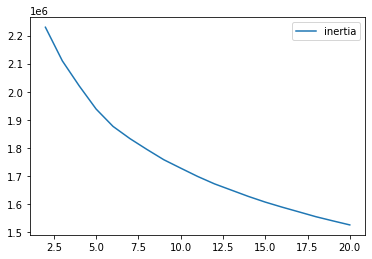

In [22]:
kMeans_inertia.plot()

### 클러스터링 결과 평가

In [23]:
def analyzeCluster(clusterDF, labelsDF):

    # 각 군집의 할당된 관측치 개수를 계산
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    
    # 실제 라벨 배열과 clusterDF와 병합
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns = ['trueLabel', 'cluster']
    
    # 훈련 셋에 있는 실제 레이블 데이터 개수를 계산
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    # 각 군집별 가장 자주 발생하는 숫자의 개수를 저장
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster')\
                                 .agg(lambda x : x.value_counts().iloc[0]))
    
    countMostFreq.reset_index(inplace=True,drop=False)

    countMostFreq.columns = ['cluster','countMostFrequent']
    
    # 군집의 정확도 = 모든 군집별로 가장 자주 발생하는 관측치 개수의 합을 훈련 셋의 총 관측치 개수로 나눈 값
    accuracyDF = countMostFreq.merge(countByCluster, left_on="cluster", right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum() / accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent / accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [24]:
n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2022

In [25]:
kMeans_inertia = pd.DataFrame(data=[],index=range(2,21),
                              columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],
                                        index=range(2,21),
                                        columns=['overallAccuracy'])

In [26]:
for n_clusters in range(2,21):

    kmeans = KMeans(n_clusters=n_clusters,
                    n_init=n_init,
                    max_iter=max_iter,
                    tol=tol,
                    random_state=random_state)

    cutoff = 99

    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:, 0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered,
                                           index=X_train.index,
                                           columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
    accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
    = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

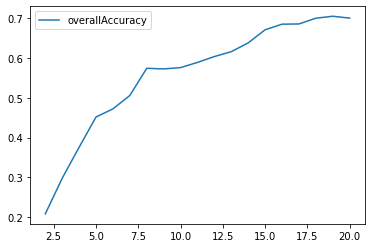

In [28]:
overallAccuracy_kMeansDF.plot()

In [27]:
accuracyByLabel_kMeans

0     0.456813
1     0.944000
2     0.635368
3     0.500539
4     0.928705
5     0.956995
6     0.380286
7     0.402020
8     0.873804
9     0.849296
10    0.587485
11    0.520331
12    0.889807
13    0.931747
14    0.843784
15    0.780089
16    0.916667
17    0.709954
18    0.461870
19    0.951499
dtype: float64

### k - 평균과 주성분 개수

* 클러스터링 알고리즘이 사용하는 주성분 개수에 따라 군집의 동질성 (정확도)에 어떤 영향을 미치는지 평가

In [29]:
n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2022

In [30]:
kMeans_inertia = pd.DataFrame(data=[],
                              index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 783],
                              columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],
                                        index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 783],
                                        columns=['overallAccuracy'])

In [31]:
for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:

    kmeans = KMeans(n_clusters=n_clusters,
                    n_init=n_init,
                    max_iter=max_iter,
                    tol=tol, 
                    random_state=random_state)
    
    cutoff = cutoffNumber

    kmeans.fit(X_train_PCA.loc[:, 0:cutoff])

    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered,
                                           index=X_train.index,
                                           columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
    accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
    = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

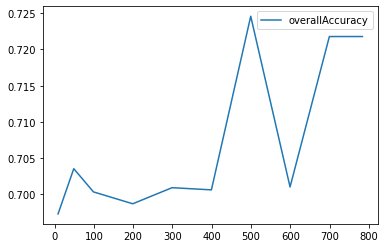

In [32]:
overallAccuracy_kMeansDF.plot()

## 계층적 클러스터링

* 특정한 군집의 개수를 사전에 설정하지 않음

* 대신 계층적 클러스터링 실행이 종료되면 우리가 원하는 군집의 개수를 선택할 수 있음

* 데이터 셋의 관측치를 사용해 덴드로그램을 만듬

* 덴드로그램은 트리 잎이 아래쪽에 있고 나무 줄기가 맨 위에 있는 뒤집힌 트리로 나타낼 수 있다

* 맨 아래 잎은 데이터 셋의 개별 인스턴스이디

* 계층적 클러스터링은 서로 얼마나 유사한지에 따라 뒤집힌 트리를 수직 위로 이동시키면서 잎을 결합시킨다

* 서로 가장 유사한 인스턴스는 더욱 빨리 결합하고 유사하지 않은 인스턴스는 나중에 결합한다

* 이러한 과정이 반복되면서 모든 인스턴스는 결국 트리의 단일 줄기를 형성하면서 서로 합쳐진다

* 덴드로그램을 보고 트리를 잘나낼 위치를 결정할 수 있다

* 더 낮은 곳을 잘라낼수록 개별가지 (군집)가 더 많이 남는다

* 군집 수를 줄이려면 덴드로그램에서 더 높은 곳을 자르면 된다

### 병합 계층적 클러스터링

* 행렬 Z를 반환함

* 데이터 셋의 각 관측치를 단일 포인트 군집으로 처리하고 각 반복 훈련마다 알고리즘은 최소 거리를 가진 두 군집을 병합함

* 처음에는 단지 단일 포인트 군집 간 병합을 시도하지만 계속 진행됨에 따라 다른 다중 포인트 군집과 단일 포인트 또는 다중 포인트 군집 간 병합을 함

* 결국 이러한 반복 프로세스로 모든 클러스터가 함께 병합돼 뒤집힌 트리의 줄기를 형성함

**method**

* 군집 간 거리를 측정하는 방법

* single

  - 각 군집에 속하는 임의의 개체들 간 거리 중 최단거리

* centroid : 중심 연결법

  - 각 군집에 중심점 간 거리

* median : 중위수 연결법

  - 각 군집에 속하는 임의의 객체들 간 거리 중 중위수로 군집 간 거리를 정의

* ward 

  - 각 군집 별로 구성 가능한 모든 분산을 구하고 분산이 가장 적은 군집으로 클러스터링

* centroid, median, ward인 경우 metric을 euclidean으로 설정해야 함

In [33]:
cutoff = 99

Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff],
                               method='ward',
                               metric='euclidean')


Z_dataFrame = pd.DataFrame(data=Z,
                           columns=['clusterOne', 'clusterTwo',
                                    'distance','newClusterSize'])

* clusterOne과 clusterTwo는 각각 단일 포인트 군집 (원본 관측치) 또는 다중 포인트 군집일 수 있으며, 이 두 군집이 서로 상대적인 거리를 고려해 병합되는 과정을 보여줌

* 이 상대적인 거리는 세 번째 컬럼인 distance에 표시되며, 이는 클러스터링 알고리즘의 설정 값인 ward 방법과 euclidean 척도에 의해 결정됨

In [34]:
Z_dataFrame.head(15)

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562683,2.0
1,28350.0,37674.0,0.590866,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627761,2.0
4,24707.0,43151.0,0.637667,2.0
5,20465.0,24483.0,0.662558,2.0
6,466.0,42098.0,0.664189,2.0
7,46542.0,49961.0,0.665520,2.0
8,2301.0,5732.0,0.671215,2.0
9,37564.0,47668.0,0.675122,2.0


* 거리는 단조롭게 증가하고 있다

* 즉, 최단 거리 군집이 먼저 병합되고 알고리즘의 모든 점이 덴드로 그램 가장 위에 있는 단일 군집으로 결합될 때까지 다음 최단 거리 군집을 반복적으로 병합

In [36]:
Z_dataFrame.tail(15)

,clusterOne,clusterTwo,distance,newClusterSize
49984,99974.0,99979.0,185.027875,7744.0
49985,99940.0,99975.0,185.345204,5596.0
49986,99957.0,99967.0,211.854713,5957.0
49987,99938.0,99983.0,215.494823,4846.0
49988,99978.0,99984.0,216.760340,11072.0
49989,99970.0,99973.0,217.355883,4899.0
49990,99969.0,99986.0,225.468314,8270.0
49991,99981.0,99982.0,238.845118,9750.0
49992,99968.0,99977.0,266.146849,5567.0
49993,99985.0,99989.0,270.929469,10495.0


### 클러스터링 결과 평가하기

In [37]:
distance_threshold = 160

clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters,
                                     index=X_train_PCA.index,
                                     columns=['cluster'])

In [38]:
print("Number of distinct clusters: ", 
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  20


In [39]:
countByCluster_hierClust, countByLabel_hierClust, \
countMostFreq_hierClust, accuracyDF_hierClust, \
overallAccuracy_hierClust, accuracyByLabel_hierClust \
= analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ",
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76882


In [40]:
accuracyByLabel_hierClust

0     0.987962
1     0.983727
2     0.988998
3     0.597356
4     0.678642
5     0.442478
6     0.950033
7     0.829060
8     0.976062
9     0.986141
10    0.990183
11    0.992183
12    0.971033
13    0.554273
14    0.553617
15    0.720183
16    0.538891
17    0.484590
18    0.957732
19    0.977310
dtype: float64

## DBSCAN

* 데이터 포인트의 밀도에 따라 그룹화

* 밀접하게 묶인 포인트를 함께 그룹화

  - 밀접하게 묶인 : 특정 거리 내에 존재해야 하는 데이터의 최소 개수로 정의

* 만약 어떤 데이터 포인트가 여러 군집의 특정 거리 내에 있으면 그 포인트는 그 중에서 가장 밀도가 높은 군집과 그룹화한다

* 그리고 다른 군집의 특정 거리 내에 있지 않는 인스턴스는 모두 이상치로 표시

* DBSCAN에서는 데이터 포인트에 이상치가 명시적으로 지정되고 클러스터링에서 제외된다

* 이로 인해 DBSCAN은 다른 클러스터링 알고리즘에 비해 데이터의 이상치 떄문에 일반적으로 발생하는 왜곡이 훨씬 적다

* 군집 수를 미리 설정할 필요가 없다

* eps (최대 거리)

  - eps가 너무 낮게 설정되면 같은 이웃으로 고려할 포인트가 없울 수 있다
  - 이렇게 되면 모든 포인트가 클러스터링되지 않은 상태로 남아 있게 된다
  - eps가 너무 높게 설정되면 대부분 포인트가 클러스터링돼 소수의 포인트만 클러스터링되지 않은 상태로 남아 데이터 셋에 있는 이상치를 효과적으로 분류할 수 있다

* min_samples

  - 포인트 군집이 되기 위해 eps 거리 내에 포인트가 얼마나 많아야 하는지를 설정

  - 밀접하게 위치한 포인트들이 최소 샘플 수 이상 존재하면 소위 중심정으로부터 eps 거리 내에 있는 다른 포인트는 해당 군집의 다른 군집의 일부가 된다

  - 일반적으로 최소 샘플 수가 증가하면 군집 수가 증가한다

In [41]:
eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 1

In [44]:
db = DBSCAN(eps=eps,
            min_samples=min_samples,
            leaf_size=leaf_size, 
            n_jobs=n_jobs)

In [45]:
cutoff = 99

X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:, 0:cutoff])
X_train_PCA_dbscanClustered = pd.DataFrame(data=X_train_PCA_dbscanClustered,
                                           index=X_train.index,
                                           columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
= analyzeCluster(X_train_PCA_dbscanClustered, y_train)

print(overallAccuracy_dbscan)

0.242


In [46]:
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.242


In [47]:
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,39575
1,0,8885
2,8,720
3,5,92
4,18,51
...,...,...
95,85,4
96,57,4
97,92,4
98,54,3


## HDBSCAN

* 밀도를 기반으로 그룹화하고, 앞에서 소개한 계층적 클러스터링처럼 거리를 기준으로 밀도 기반 군집을 반복적으로 연결한다

In [48]:
min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

In [52]:
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                      min_samples=min_samples,
                      alpha=alpha,
                      cluster_selection_method=cluster_selection_method)

cutoff = 10
X_train_PCA_hdbscanClustered = hdb.fit_predict(X_train_PCA.loc[:, 0:cutoff])

X_train_PCA_hdbscanClustered = pd.DataFrame(data=X_train_PCA_hdbscanClustered,
                                            index=X_train.index,
                                            columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
countMostFreq_hdbscan, accuracyDF_hdbscan, \
overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
= analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

In [53]:
print("Overall accuracy from HDBSCAN: ",overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.24694


In [54]:
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,42569
1,4,5140
2,6,943
3,0,605
4,7,294
5,3,252
6,1,119
7,5,45
8,2,33
